In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

from torch.utils.data import Dataset, DataLoader, BatchSampler, random_split
from torchvision import transforms
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create Dataset class for multilabel classification
class MultiClassImageDataset(Dataset):
    def __init__(self, ann_df, super_map_df, sub_map_df, img_dir, transform=None):
        self.ann_df = ann_df
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ann_df)

    def __getitem__(self, idx):
        img_name = self.ann_df['image'][idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        super_idx = self.ann_df['superclass_index'][idx]
        super_label = self.super_map_df['class'][super_idx]

        sub_idx = self.ann_df['subclass_index'][idx]
        sub_label = self.sub_map_df['class'][sub_idx]

        if self.transform:
            image = self.transform(image)

        return image, super_idx, super_label, sub_idx, sub_label

class MultiClassImageTestDataset(Dataset):
    def __init__(self, super_map_df, sub_map_df, img_dir, transform=None):
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): # Count files in img_dir
        return len([fname for fname in os.listdir(self.img_dir)])

    def __getitem__(self, idx):
        img_name = str(idx) + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

In [ ]:
train_ann_df = pd.read_csv('/content/drive/MyDrive/NNProject/train_data.csv')
super_map_df = pd.read_csv('/content/drive/MyDrive/NNProject/superclass_mapping.csv')
sub_map_df = pd.read_csv('/content/drive/MyDrive/NNProject/subclass_mapping.csv')

train_img_dir = '/content/drive/MyDrive/NNProject/train_shuffle'
test_img_dir = '/content/drive/MyDrive/NNProject/test_shuffle'

image_preprocessing = transforms.Compose([
    # argumantation
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

    transforms.ToTensor(),
    transforms.Normalize(mean=(0), std=(1)),
])

# Create train and val split
train_dataset = MultiClassImageDataset(train_ann_df, super_map_df, sub_map_df,
                                       train_img_dir, transform=image_preprocessing)
train_dataset, val_dataset = random_split(train_dataset, [0.9, 0.1])

# Create test dataset
test_dataset = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir,
                                          transform=image_preprocessing)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=1,
                         shuffle=False)

(-0.5, 31.5, 31.5, -0.5)

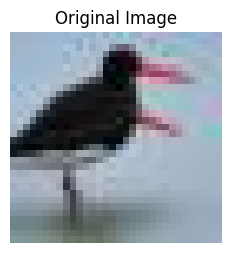

In [ ]:
img_path = '/content/drive/MyDrive/NNProject/train_shuffle/1.jpg'
original_image = Image.open(img_path).convert('RGB')

# Display the original image
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

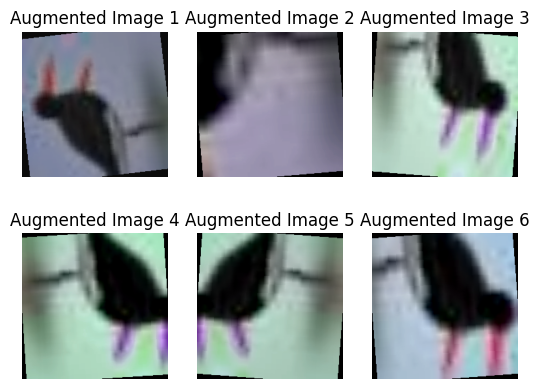

In [ ]:
# Display 6 augmented images
for i in range(1, 7):
    augmented_image = image_preprocessing(original_image)

    plt.subplot(2, 3, i)
    plt.title(f'Augmented Image {i}')
    plt.imshow(torch.transpose(augmented_image, 0, 2).numpy())
    plt.axis('off')

plt.show()

## Real_ESRGAN Model

### Install Packages

In [40]:
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git

  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-4juve6s3
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-4juve6s3
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... done
  Created wheel for RealESRGAN: filename=RealESRGAN-1.0-py3-none-any.whl size=9106 sha256=47979acc907854f366ca0dcd862ed5d81aa4baf34dfd888560a1a463bffb1981
  Stored in directory: /tmp/pip-ephem-wheel-cache-yzuxbymz/wheels/dd/a3/7d/774508ed192455403be294c8a6c4ad1c83dde8fcdd8903e64a
Successfully built RealESRGAN


In [46]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 755, done.
remote: Total 755 (delta 0), reused 0 (delta 0), pack-reused 755
Receiving objects: 100% (755/755), 5.37 MiB | 25.21 MiB/s, done.
Resolving deltas: 100% (410/410), done.
/content/Real-ESRGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.4 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214817 sha256=fb001c06321de52736e84bea3ddb449b043d4fabc983349f7f4b400272556fa8
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f30ca
Successfully built basicsr
  Atte

In [41]:
#@title Create model
from RealESRGAN import RealESRGAN
from PIL import Image
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

model_scale = "4" #@param ["2", "4", "8"] {allow-input: false}

model = RealESRGAN(device, scale=int(model_scale))
model.load_weights(f'weights/RealESRGAN_x{model_scale}.pth')

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:672: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


RealESRGAN_x4.pth:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

Weights downloaded to: weights/RealESRGAN_x4.pth


In [45]:
#@title Upload and upscale images or .tar archives
import os
from google.colab import files
import shutil
from io import BytesIO
import io
import tarfile

upload_folder = 'inputs'
result_folder = 'results'

os.makedirs(upload_folder, exist_ok=True)
os.makedirs(result_folder, exist_ok=True)

IMAGE_FORMATS = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')

def image_to_tar_format(img, image_name):
    buff = BytesIO()
    if '.png' in image_name.lower():
        img = img.convert('RGBA')
        img.save(buff, format='PNG')
    else:
        img.save(buff, format='JPEG')
    buff.seek(0)
    fp = io.BufferedReader(buff)
    img_tar_info = tarfile.TarInfo(name=image_name)
    img_tar_info.size = len(buff.getvalue())
    return img_tar_info, fp

def process_tar(path_to_tar):
    processing_tar = tarfile.open(path_to_tar, mode='r')
    result_tar_path = os.path.join('results/', os.path.basename(path_to_tar))
    save_tar = tarfile.open(result_tar_path, 'w')

    for c, member in enumerate(processing_tar):
        print(f'{c}, processing {member.name}')

        if not member.name.endswith(IMAGE_FORMATS):
            continue

        try:
            img_bytes = BytesIO(processing_tar.extractfile(member.name).read())
            img_lr = Image.open(img_bytes, mode='r').convert('RGB')
        except Exception as err:
            print(f'Unable to open file {member.name}, skipping')
            continue

        img_sr = model.predict(np.array(img_lr))
        # adding to save_tar
        img_tar_info, fp = image_to_tar_format(img_sr, member.name)
        save_tar.addfile(img_tar_info, fp)

    processing_tar.close()
    save_tar.close()
    print(f'Finished! Archive saved to {result_tar_path}')

def process_input(filename):
    if tarfile.is_tarfile(filename):
        process_tar(filename)
    else:
        result_image_path = os.path.join('results/', os.path.basename(filename))
        image = Image.open(filename).convert('RGB')
        sr_image = model.predict(np.array(image))
        sr_image.save(result_image_path)
        #sr_image.show()
        print(f'Finished! Image saved to {result_image_path}')

# upload files
uploaded = files.upload()
for filename in uploaded.keys():
    print('Processing:', filename)
    process_input(filename)

Saving 0.jpg to 0.jpg
Processing: 0.jpg
Finished! Image saved to results/0.jpg


In [52]:
import os
from google.colab import files
import shutil

upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  #print(f'move {filename} to {dst_path}')
  #shutil.move(filename, dst_path)

Saving 0.jpg to 0.jpg


In [50]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('Real-ESRGAN output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob

input_folder = 'upload'
result_folder = 'results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)

### Train Dataset

In [53]:
from RealESRGAN import RealESRGAN
from PIL import Image
import numpy as np
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

model_scale = "4"  # Choose the desired scale
model = RealESRGAN(device, scale=int(model_scale))
model.load_weights(f'weights/RealESRGAN_x{model_scale}.pth')

upload_folder = '/content/drive/MyDrive/NNProject/train_shuffle'  # Replace with your image folder path
result_folder = '/content/drive/MyDrive/NNProject/results'  # Replace with your desired result folder path

os.makedirs(upload_folder, exist_ok=True)
os.makedirs(result_folder, exist_ok=True)

IMAGE_FORMATS = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')

def process_image(image_path):
    result_image_path = os.path.join(result_folder, os.path.basename(image_path))
    image = Image.open(image_path).convert('RGB')
    sr_image = model.predict(np.array(image))
    sr_image.save(result_image_path)
    print(f'Finished! Image saved to {result_image_path}')

# Process images in the specified folder
for filename in os.listdir(upload_folder):
    if filename.endswith(IMAGE_FORMATS):
        image_path = os.path.join(upload_folder, filename)
        print('Processing:', image_path)
        process_image(image_path)

device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:672: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


RealESRGAN_x4.pth:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Processing: /content/drive/MyDrive/NNProject/train_shuffle/652.jpg
Finished! Image saved to /content/drive/MyDrive/NNProject/results/652.jpg
Processing: /content/drive/MyDrive/NNProject/train_shuffle/5146.jpg
Finished! Image saved to /content/drive/MyDrive/NNProject/results/5146.jpg
Processing: /content/drive/MyDrive/NNProject/train_shuffle/4258.jpg
Finished! Image saved to /content/drive/MyDrive/NNProject/results/4258.jpg
Processing: /content/drive/MyDrive/NNProject/train_shuffle/2195.jpg
Finished! Image saved to /content/drive/MyDrive/NNProject/results/2195.jpg
Processing: /content/drive/MyDrive/NNProject/train_shuffle/313.jpg
Finished! Image saved to /content/drive/MyDrive/NNProject/results/313.jpg
Processing: /content/drive/MyDrive/NNProject/train_shuffle/4241.jpg
Finished! Image saved to /content/drive/MyDrive/NNProject/results/4241.jpg
Processing: /content/drive/MyDrive/NNProject/train_shuffle/878.jpg
Finished! Image saved to /co

### Test Dataset

In [ ]:
from RealESRGAN import RealESRGAN
from PIL import Image
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

model_scale = "4"  # Choose the desired scale
model = RealESRGAN(device, scale=int(model_scale))
model.load_weights(f'weights/RealESRGAN_x{model_scale}.pth')

upload_folder = '/content/drive/MyDrive/NNProject/test_shuffle'  # Replace with your image folder path
result_folder = '/content/drive/MyDrive/NNProject/results_test'  # Replace with your desired result folder path

os.makedirs(upload_folder, exist_ok=True)
os.makedirs(result_folder, exist_ok=True)

IMAGE_FORMATS = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')

def process_image(image_path):
    result_image_path = os.path.join(result_folder, os.path.basename(image_path))
    image = Image.open(image_path).convert('RGB')
    sr_image = model.predict(np.array(image))
    sr_image.save(result_image_path)
    print(f'Finished! Image saved to {result_image_path}')

# Process images in the specified folder
for filename in os.listdir(upload_folder):
    if filename.endswith(IMAGE_FORMATS):
        image_path = os.path.join(upload_folder, filename)
        print('Processing:', image_path)
        process_image(image_path)

## ESRI Model for tesing

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out

class EDSR(nn.Module):
    def __init__(self, num_residual_blocks=16, scaling_factor=2):
        super(EDSR, self).__init__()

        self.head = nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1)

        residual_blocks = []
        for _ in range(num_residual_blocks):
            residual_blocks.append(ResidualBlock(256, 256, kernel_size=3, stride=1, padding=1))

        self.body = nn.Sequential(*residual_blocks)

        self.tail = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(scaling_factor),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        out = self.head(x)
        residual = out
        out = self.body(out)
        out += residual
        out = self.tail(out)
        return out

# Instantiate the model
edsr_model = EDSR()

# Print the model architecture
print(edsr_model)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def increase_resolution_fixed_size(image_path, target_width, target_height):
    # Open the image
    original_image = Image.open(image_path)

    # Resize the image to the target resolution using bicubic interpolation
    high_res_image = original_image.resize((target_width, target_height), Image.BICUBIC)

    # Display the original and high-resolution images side by side using Matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display the high-resolution image
    axes[1].imshow(high_res_image)
    axes[1].set_title('High-Resolution Image')
    axes[1].axis('off')

    plt.show()

    # Save the high-resolution image
    # high_res_image.save('high_resolution_image.jpg')

# Example usage
image_path = '/content/drive/MyDrive/NNProject/train_shuffle/1.jpg'
target_width = 32  # Adjust the target width based on your requirement
target_height = 32  # Adjust the target height based on your requirement

increase_resolution_fixed_size(image_path, target_width, target_height)

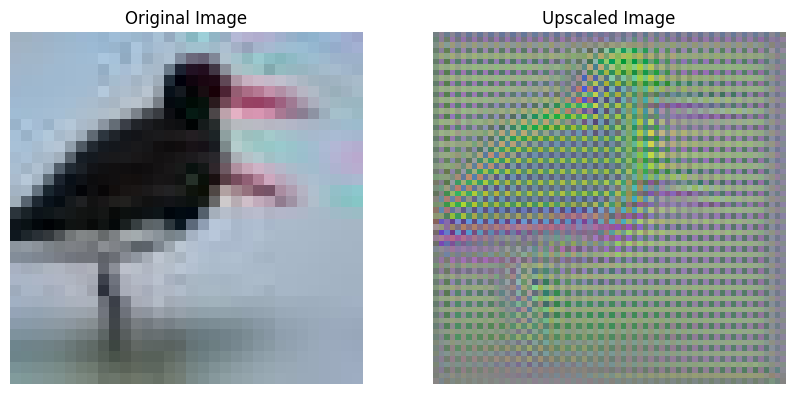

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the EDSR model
edsr_model = EDSR()
# Load pre-trained weights (if available)
# eds_model.load_state_dict(torch.load('edsr_pretrained_weights.pth'))
edsr_model.eval()

# Load the original image
original_image_path = '/content/drive/MyDrive/NNProject/train_shuffle/1.jpg'
original_image = Image.open(original_image_path).convert('RGB')

# Preprocess the input image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
input_image = preprocess(original_image).unsqueeze(0)

# Upscale the image using the EDSR model
with torch.no_grad():
    upscaled_image = edsr_model(input_image)

# Post-process the upscaled image
postprocess = transforms.Compose([
    transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
    transforms.ToPILImage()
])
upscaled_image = postprocess(upscaled_image.squeeze(0))

# Display the original and upscaled images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(upscaled_image)
axes[1].set_title('Upscaled Image')
axes[1].axis('off')

plt.show()